# Actors


In this tutorial, we demonstrate how getML can be applied in an e-commerce context. Using a dataset of about 400,000 orders, our goal is to predict whether an order will be cancelled.

We also show that we can significantly improve our results by using getML's built-in hyperparameter tuning routines.

Summary:

- Prediction type: __Classification model__
- Domain: __E-commerce__
- Prediction target: __The gender of an actor__ 
- Population size: __817718__

_Author: Dr. Patrick Urbanke_

# Background

The data set contains about 400,000 orders from a British online retailer. Each order consists of a product that has been ordered and a corresponding quantity. Several orders can be summarized onto a single invoice. The goal is to predict whether an order will be cancelled.

Because the company mainly sells to other businesses, the cancellation rate is relatively low, namely 1.83%.

The data set has been originally collected for this study:

Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197-208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).

It has been downloaded from the UCI Machine Learning Repository:

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

from sklearn.feature_extraction.text import CountVectorizer

import getml

getml.engine.set_project('actors')


Connected to project 'actors'


Tuning is effective at improving our results, but it takes quite long, so we want to make it optional:

## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the source file:

In [2]:
conn = getml.database.connect_mariadb(
    host="relational.fit.cvut.cz",
    dbname="imdb_ijs",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(conn_id='default', dbname='imdb_ijs', dialect='mysql', 
           host='relational.fit.cvut.cz', port=3306)

In [3]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [4]:
actors = load_if_needed("actors")
roles = load_if_needed("roles")
movies = load_if_needed("movies")
movies_genres = load_if_needed("movies_genres")

In [5]:
actors

Name,id,rownum,target,first_name,last_name,gender
Role,join_key,join_key,target,unused_string,unused_string,unused_string
0,2,0,0,Michael,'babeepower' Viera,M
1,3,1,0,Eloy,'Chincheta',M
2,4,2,0,Dieguito,'El Cigala',M
3,5,3,0,Antonio,'El de Chipiona',M
4,6,4,0,José,'El Francés',M
,...,...,...,...,...,...
817713,845461,817713,1,Herdís,Þorvaldsdóttir,F
817714,845462,817714,1,Katla Margrét,Þorvaldsdóttir,F
817715,845463,817715,1,Lilja Nótt,Þórarinsdóttir,F


In [6]:
roles

Name,actor_id,movie_id,rownum,role
Role,join_key,join_key,join_key,unused_string
0,2,280088,0,Stevie
1,2,396232,1,Various/lyricist
2,3,376687,2,Gitano 1
3,4,336265,3,El Cigala
4,5,135644,4,Himself
,...,...,...,...
3431961,845461,137097,3431961,Kata
3431962,845462,208838,3431962,Magga
3431963,845463,870,3431963,Gunna


In [7]:
movies

Name,id,year,rank,name
Role,join_key,numerical,numerical,unused_string
0,0,2002,nan,#28
1,1,2000,nan,"#7 Train: An Immigrant Journey, The"
2,2,1971,6.4,$
3,3,1913,nan,"$1,000 Reward"
4,4,1915,nan,"$1,000 Reward"
,...,...,...,...
388264,412316,1991,nan,"""zem blch krlu"""
388265,412317,1995,nan,"""rgammk"""
388266,412318,2002,nan,"""zgnm Leyla"""


In [8]:
movies_genres

Name,movie_id,genre
Role,join_key,categorical
0,1,Documentary
1,1,Short
2,2,Comedy
3,2,Crime
4,5,Western
,...,...
395114,378612,Adventure
395115,378612,Drama
395116,378613,Comedy


### 1.2 Prepare data for getML

In [9]:
def fit_transform_count_vectorizer(text_fields):
    count_vectorizer = CountVectorizer(min_df=11)
    transformed = count_vectorizer.fit_transform(text_fields)
    return count_vectorizer.inverse_transform(transformed)

In [10]:
def make_data_frame(transformed_text_fields, df_name):
    join_keys = []
    indices = []
    words = []
    #
    for i, trans in enumerate(transformed_text_fields):
        join_keys += [i] * len(trans)
        indices += range(len(trans.tolist()))
        words += trans.tolist()
    #
    data_frame = pd.DataFrame()
    data_frame["join_key"] = join_keys
    data_frame["index"] = indices
    data_frame["words"] = words
    #
    return getml.data.DataFrame.from_pandas(data_frame, df_name)

In [11]:
def process_text_fields(text_fields, df_name):
    transformed_text_fields = fit_transform_count_vectorizer(text_fields)
    return make_data_frame(transformed_text_fields, df_name)

In [12]:
first_names = actors.first_name.to_numpy()
first_names = process_text_fields(first_names, "first_names")
first_names

Name,join_key,index,words
Role,unused_float,unused_float,unused_string
0,0,0,michael
1,1,0,eloy
2,3,0,antonio
3,4,0,josé
4,5,0,félix
,...,...,...
788097,817692,0,liliane
788098,817695,0,meral
788099,817703,0,fatma


In [13]:
role = roles.role.to_numpy()
role = process_text_fields(role, "role")
role

Name,join_key,index,words
Role,unused_float,unused_float,unused_string
0,0,0,stevie
1,1,0,lyricist
2,1,1,various
3,2,0,gitano
4,3,0,el
,...,...,...
4018929,3431945,0,1997
4018930,3431945,1,1996
4018931,3431958,0,lilja


getML requires that we define *roles* for each of the columns.

In [14]:
actors["target"] = (actors.gender == 'F').as_num()
actors["rownum"] = actors.rowid()

In [15]:
actors.set_role(["id", "rownum"], getml.data.roles.join_key)
actors.set_role("target", getml.data.roles.target)

In [16]:
roles["rownum"] = roles.rowid()
roles.set_role(["actor_id", "movie_id", "rownum"], getml.data.roles.join_key)

In [17]:
movies.set_role("id", getml.data.roles.join_key)
movies.set_role(["year", "rank"], getml.data.roles.numerical)

In [18]:
movies_genres.set_role("movie_id", getml.data.roles.join_key)
movies_genres.set_role("genre", getml.data.roles.categorical)

In [19]:
first_names.set_role("join_key", getml.data.roles.join_key)
first_names.set_role("index", getml.data.roles.numerical)
first_names.set_role("words", getml.data.roles.categorical)

In [20]:
role.set_role("join_key", getml.data.roles.join_key)
role.set_role("index", getml.data.roles.numerical)
role.set_role("words", getml.data.roles.categorical)

The *StockCode* is a 5-digit code that uniquely defines a product. It is hierarchical, meaning that every digit has a meaning. We want to make use of that, so we assign a unit to the stock code, which we can reference in our preprocessors.

Let's take a look at what we have done so far:

In [21]:
random = actors.random()

is_training = (random < 0.7)
is_validation = (~is_training & (random < 0.85))
is_test = (~is_training & ~is_validation)

data_train = actors.where("data_train", is_training)
data_validation = actors.where("data_validation", is_validation)
data_test = actors.where("data_test", is_test)

## 2. Predictive modelling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

### 2.1 Define relational model

To get started with relational learning, we need to specify the data model.

In our case, there are two joins we are interested in: 

1) We want to take a look at all of the other orders on the same invoice.

2) We want to check out how often a certain customer has cancelled orders in the past. Here, we limit ourselves to the last 90 days. To avoid data leaks, we set a horizon of one day.

In [22]:
actors_ph = getml.data.Placeholder('actors')
first_names_ph = getml.data.Placeholder('first_names')
roles_ph = getml.data.Placeholder('roles')
role_ph = getml.data.Placeholder('role')
movies_ph = getml.data.Placeholder('movies')
movie_genres_ph = getml.data.Placeholder('movie_genres')

#actors_ph.join(
#    first_names_ph,
#    join_key='rownum',
#    other_join_key='join_key'
#)

actors_ph.join(
    roles_ph,
    join_key='id',
    other_join_key='actor_id'
)

roles_ph.join(
    role_ph,
    join_key='rownum',
    other_join_key='join_key'
)

roles_ph.join(
    movies_ph,
    join_key='movie_id',
    other_join_key='id',
    relationship=getml.data.relationship.many_to_one
)

movies_ph.join(
    movie_genres_ph,
    join_key='id',
    other_join_key='movie_id'
)

actors_ph

placeholder   other placeholder   allow lagged targets   horizon   join keys used   ...   
actors        roles               False                  0.0       id               ...   
roles         role                False                  0.0       rownum           ...   
roles         movies              False                  0.0       movie_id         ...   
movies        movie_genres        False                  0.0       id               ...   



other join keys used   other time stamps used   relationship   time stamps used   
actor_id                                        many-to-many                      
join_key                                        many-to-many                      
id                                              many-to-one                       
movie_id                                        many-to-many                      



other join keys used   upper time stamps used   
actor_id                                        
join_key                                        
id                                              
movie_id

### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We have mentioned that the *StockCode* is a hierarchical code. To make use of that fact, we use getML's substring preprocessor, extracting the first digit, the first two digits etc. Since we have assigned the unit *code* to the *StockCode*, the preprocessors know which column they should be applied to.

In [36]:
relboost = getml.feature_learning.RelboostModel(
    num_features=30,
    num_subfeatures=10,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    seed=4367,
    num_threads=1
)

predictor = getml.predictors.XGBoostClassifier()

__Build the pipeline__

In [37]:
pipe = getml.pipeline.Pipeline(
    tags=['relboost'],
    population=actors_ph,
    peripheral=[roles_ph, movies_ph, movie_genres_ph, first_names_ph, role_ph],
    feature_learners=[relboost],
    predictors=[predictor]
)

### 2.3 Model training

In [25]:
pipe.check(data_train, {"roles": roles, "movies": movies, "movie_genres": movies_genres, "first_names": first_names, "role": role})

Checking data model...


INFO [MIGHT TAKE LONG]: The number of unique entries in column 'words' in  data frame 'role' is 30324. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
INFO [JOIN KEYS NOT FOUND]: When joining the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins and  data frame 'role' over 'rownum' and 'join_key', there are no corresponding entries for 32.398544% of entries in 'rownum' in 'the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins'. You might want to double-check your join keys.
INFO [JOIN KEYS NOT FOUND]: When joining the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins and  data frame 'movie_genres' over 'id' and 'movie_id', there are no corresponding entries for 26.899421% of entries in 'id

In [38]:
pipe.fit(data_train, {"roles": roles, "movies": movies, "movie_genres": movies_genres, "first_names": first_names, "role": role})

Checking data model...


INFO [MIGHT TAKE LONG]: The number of unique entries in column 'words' in  data frame 'role' is 30324. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
INFO [JOIN KEYS NOT FOUND]: When joining the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins and  data frame 'role' over 'rownum' and 'join_key', there are no corresponding entries for 32.398544% of entries in 'rownum' in 'the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins'. You might want to double-check your join keys.
INFO [JOIN KEYS NOT FOUND]: When joining the composite data frame 'roles'-'movies' that has been created by many-to-one joins or one-to-one joins and  data frame 'movie_genres' over 'id' and 'movie_id', there are no corresponding entries for 26.899421% of entries in 'id


Relboost: Training subfeatures...
[========================================] 100%

Relboost: Training subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:35m:19.841068



Pipeline(preprocessors=[], feature_learners=['RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['roles', 'movies', 'movie_genres', 'first_names', 'role'], 
         population='actors', predictors=['XGBoostClassifier'], 
         tags=['relboost'], share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/actors/H69V39/0/

### 2.4 Model evaluation

In [39]:
in_sample = pipe.score(data_train, {"roles": roles, "movies": movies, "movie_genres": movies_genres, "first_names": first_names, "role": role})

out_of_sample = pipe.score(data_test, {"roles": roles, "movies": movies, "movie_genres": movies_genres, "first_names": first_names, "role": role})

pipe.scores


Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%


Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2020-12-22 14:02:09,data_test,target,0.83685,0.91073,0.33438
1,2020-12-22 14:01:37,data_train,target,0.83801,0.91199,0.33191


### 2.6 Studying features

__Feature correlations__

We want to analyze how the features are correlated with the target variable.

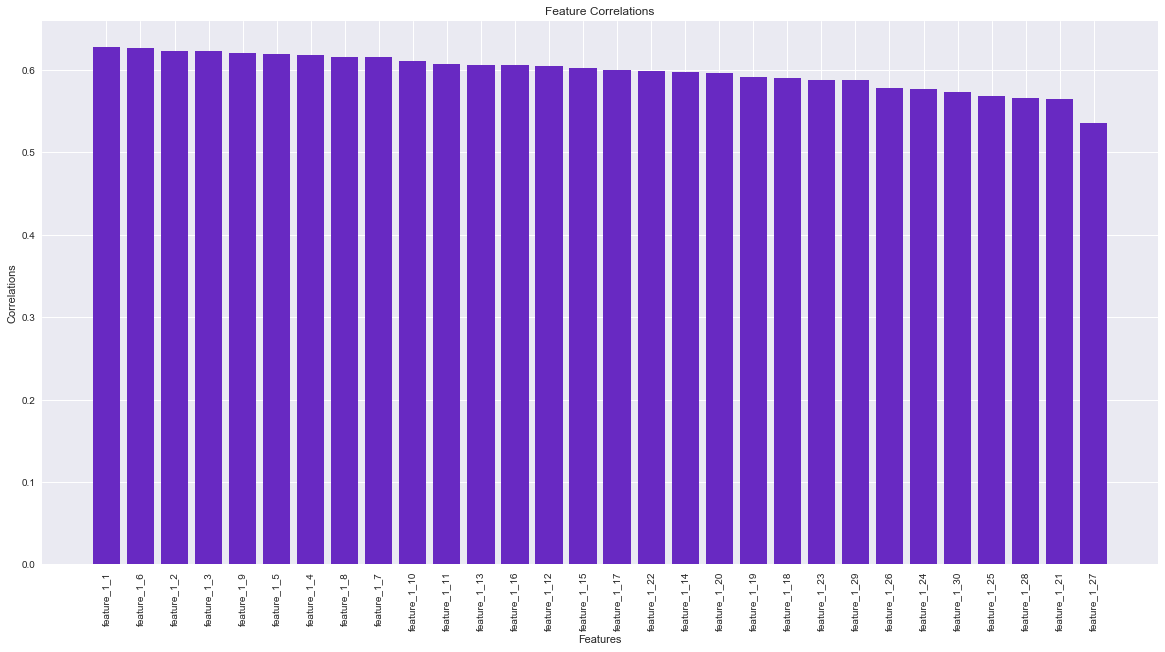

In [40]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

In [41]:
pipe.features.to_sql().save("features.sql")

__Feature importances__
 
Feature importances are calculated by analyzing the improvement in predictive accuracy on each node of the trees in the XGBoost predictor. They are then normalized, so that all importances add up to 100%.

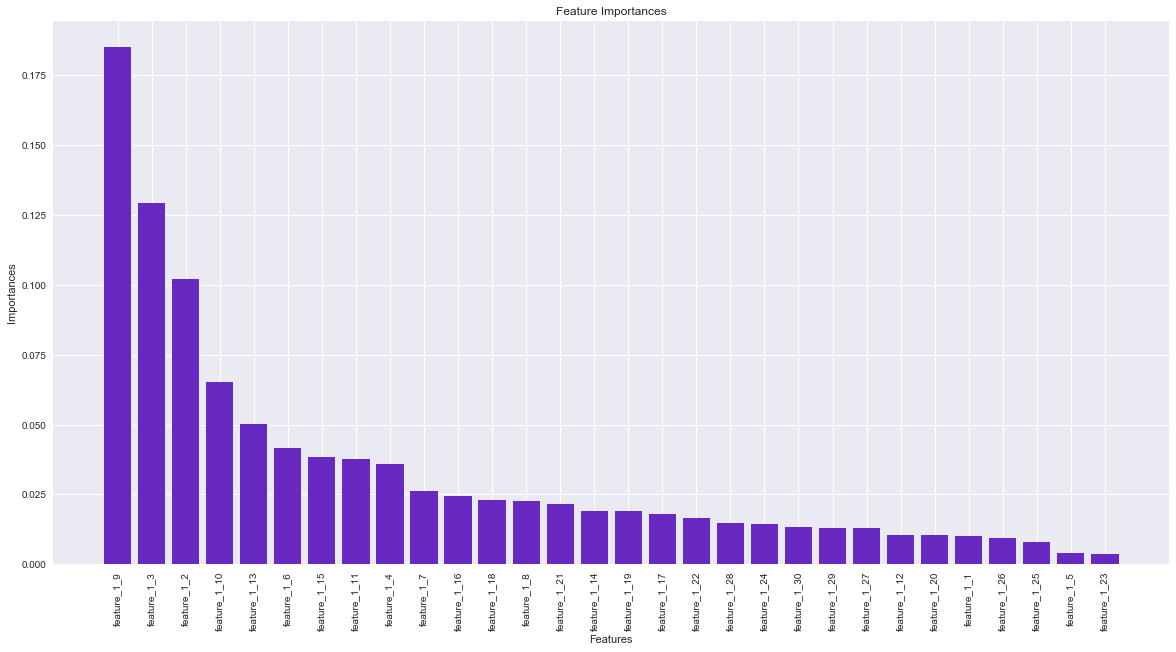

In [42]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

As we can see, the *StockCode* contributes about 50% of the predictive accuracy.

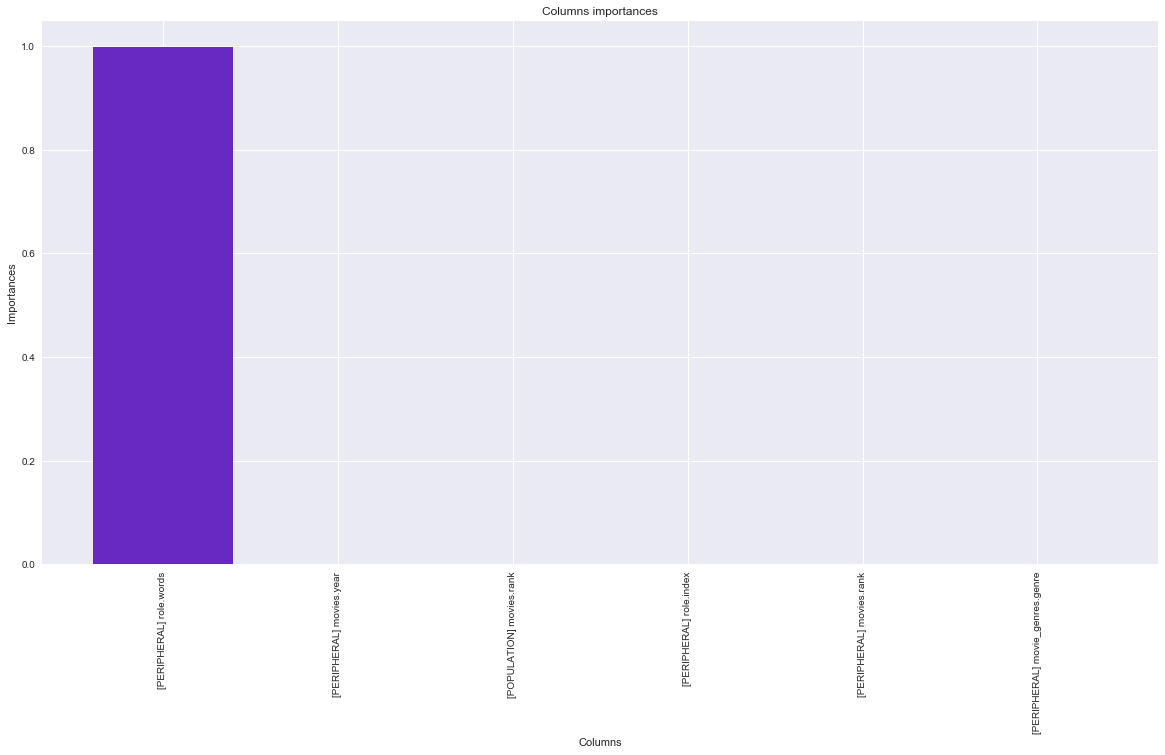

In [43]:
names, importances = pipe.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Columns importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Transpiling the learned features__

We can also transpile the learned features to SQLite3 code. We want to show the two most important features. That is why we call the `.features.importances().` method again. The names that are returned are already sorted by importance.

In [44]:
names, _ = pipe.features.importances()

pipe.features.to_sql()[names[0]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_9";

CREATE TABLE "FEATURE_1_9" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) > 0.976750 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -0.770013 ) AND ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 0.095614 ) THEN 0.2104404335969828
        WHEN ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) > 0.976750 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -0.770013 ) AND ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 0.095614 ) THEN -0.7784494012686878
        WHEN ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) > 0.976750 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -0.770013 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) > 1.381433 ) THEN 0.383579657941867
        WHEN ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) > 0.976750 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -0.770013 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) <= 1.381433 ) THEN -2.134672649623828
        WHEN ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) <= 0.976750 ) AND ( COALESCE( f_1_1_2."feature_1_1_2", 0.0 ) > -0.078755 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) > 0.568261 ) THEN -0.4115234651978266
        WHEN ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) <= 0.976750 ) AND ( COALESCE( f_1_1_2."feature_1_1_2", 0.0 ) > -0.078755 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) <= 0.568261 ) THEN -1.44451696728863
        WHEN ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) <= 0.976750 ) AND ( COALESCE( f_1_1_2."feature_1_1_2", 0.0 ) <= -0.078755 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > -0.190297 ) THEN -1.854305518514725
        WHEN ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) <= 0.976750 ) AND ( COALESCE( f_1_1_2."feature_1_1_2", 0.0 ) <= -0.078755 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= -0.190297 ) THEN -2.644727722737677
        ELSE NULL
    END
) AS "feature_1_9",
     t1.rowid AS "rownum"
FROM "actors" t1
LEFT JOIN "roles" t2
ON t1."id" = t2."actor_id"
LEFT JOIN "movies" t3
ON t2."movie_id" = t3."id"
LEFT JOIN "FEATURE_1_1_1" f_1_1_1
ON t2.rowid = f_1_1_1."rownum"
LEFT JOIN "FEATURE_1_1_2" f_1_1_2
ON t2.rowid = f_1_1_2."rownum"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_4" f_1_1_4
ON t2.rowid = f_1_1_4."rownum"
LEFT JOIN "FEATURE_1_1_6" f_1_1_6
ON t2.rowid = f_1_1_6."rownum"
LEFT JOIN "FEATURE_1_1_9" f_1_1_9
ON t2.rowid = f_1_1_9."rownum"
LEFT JOIN "FEATURE_1_1_10" f_1_1_10
ON t2.rowid = f_1_1_10."rownum"
GROUP BY t1.rowid;
```

In [45]:
names, _ = pipe.features.importances()

pipe.features.to_sql()[names[1]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_3";

CREATE TABLE "FEATURE_1_3" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 0.412141 ) AND ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) > 0.975704 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) > 0.174344 ) THEN 2.318667207226012
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 0.412141 ) AND ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) > 0.975704 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) <= 0.174344 ) THEN 1.361466629794482
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 0.412141 ) AND ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) <= 0.975704 ) AND ( COALESCE( f_1_1_2."feature_1_1_2", 0.0 ) > 0.049104 ) THEN 1.254297881205396
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 0.412141 ) AND ( COALESCE( f_1_1_1."feature_1_1_1", 0.0 ) <= 0.975704 ) AND ( COALESCE( f_1_1_2."feature_1_1_2", 0.0 ) <= 0.049104 ) THEN -0.37801025983078
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 0.412141 ) AND ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > -0.072895 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 1.357579 ) THEN 1.705829352700627
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 0.412141 ) AND ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > -0.072895 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 1.357579 ) THEN -0.05686232172955295
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 0.412141 ) AND ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= -0.072895 ) AND ( COALESCE( f_1_1_2."feature_1_1_2", 0.0 ) > -0.178800 ) THEN -0.6310083244835683
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 0.412141 ) AND ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= -0.072895 ) AND ( COALESCE( f_1_1_2."feature_1_1_2", 0.0 ) <= -0.178800 ) THEN -1.481887259024015
        ELSE NULL
    END
) AS "feature_1_3",
     t1.rowid AS "rownum"
FROM "actors" t1
LEFT JOIN "roles" t2
ON t1."id" = t2."actor_id"
LEFT JOIN "movies" t3
ON t2."movie_id" = t3."id"
LEFT JOIN "FEATURE_1_1_1" f_1_1_1
ON t2.rowid = f_1_1_1."rownum"
LEFT JOIN "FEATURE_1_1_2" f_1_1_2
ON t2.rowid = f_1_1_2."rownum"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_5" f_1_1_5
ON t2.rowid = f_1_1_5."rownum"
LEFT JOIN "FEATURE_1_1_6" f_1_1_6
ON t2.rowid = f_1_1_6."rownum"
LEFT JOIN "FEATURE_1_1_8" f_1_1_8
ON t2.rowid = f_1_1_8."rownum"
GROUP BY t1.rowid;
```

## 3. Conclusion

In this notebook we have demonstrated how getML can be applied to an e-commerce setting. In particular, we have seen how results can be improved using the built-in hyperparamater tuning routines.

# Next Steps

This tutorial went through the basics of applying getML to relational data. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__Tutorials:__
* [Loan default prediction: Introduction to relational learning](loans_demo.ipynb)
* [Occupancy detection: A multivariate time series example](occupancy_demo.ipynb)  
* [Expenditure categorization: Why relational learning matters](consumer_expenditures_demo.ipynb)
* [Disease lethality prediction: Feature engineering and the curse of dimensionality](atherosclerosis_demo.ipynb)
* [Traffic volume prediction: Feature engineering on multivariate time series](interstate94_demo.ipynb)
* [Air pollution prediction: Why feature learning outperforms brute-force approaches](air_pollution_demo.ipynb) 


__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)


# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.